### 🔹 Modeling

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import ensemble
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import warnings
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sales_forecasting_project.utils import MeanEnsemble, BoolToIntImputer

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore') 

In [22]:
train = pd.read_csv('Datasets/train.csv')
features = pd.read_csv('Datasets/features.csv')
stores = pd.read_csv('Datasets/stores.csv')
test = pd.read_csv('Datasets/test.csv')

In [23]:
feature_store = features.merge(stores, how='left', on = "Store")

feature_store['Date'] = pd.to_datetime(feature_store['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

feature_store['Day'] = feature_store['Date'].dt.day
feature_store['Week'] = feature_store['Date'].dt.isocalendar().week
feature_store['Month'] = feature_store['Date'].dt.month
feature_store['Year'] = feature_store['Date'].dt.year

In [24]:
train_merged= pd.merge(train, feature_store, on=['Store', 'Date', 'IsHoliday'], how='left')
display(train_merged.head())

test_merged = pd.merge(test, feature_store, on=['Store', 'Date', 'IsHoliday'], how='left')
display(test_merged.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,12,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,19,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,26,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,5,9,3,2010


,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,2,44,11,2012
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,9,45,11,2012
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,16,46,11,2012
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,23,47,11,2012
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,30,48,11,2012


In [25]:
train_merged['Days_to_Thansksgiving'] = (pd.to_datetime(train_merged["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(train_merged["Date"], format="%Y-%m-%d")).dt.days.astype(int)
train_merged['Days_to_Christmas'] = (pd.to_datetime(train_merged["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(train_merged["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [26]:
superbowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
labor_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

train_merged['SuperBowlWeek'] = train_merged['Date'].isin(superbowl_dates).astype(int)
train_merged['LaborDay'] = train_merged['Date'].isin(labor_dates).astype(int)
train_merged['Thanksgiving'] = train_merged['Date'].isin(thanksgiving_dates).astype(int)
train_merged['Christmas'] = train_merged['Date'].isin(christmas_dates).astype(int)

In [27]:
test_merged['Days_to_Thansksgiving'] = (pd.to_datetime(test_merged["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(test_merged["Date"], format="%Y-%m-%d")).dt.days.astype(int)
test_merged['Days_to_Christmas'] = (pd.to_datetime(test_merged["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(test_merged["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [28]:
superbowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
labor_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

test_merged['SuperBowlWeek'] = test_merged['Date'].isin(superbowl_dates).astype(int)
test_merged['LaborDay'] = test_merged['Date'].isin(labor_dates).astype(int)
test_merged['Thanksgiving'] = test_merged['Date'].isin(thanksgiving_dates).astype(int)
test_merged['Christmas'] = test_merged['Date'].isin(christmas_dates).astype(int)

In [29]:
test_merged.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year,Days_to_Thansksgiving,Days_to_Christmas,SuperBowlWeek,LaborDay,Thanksgiving,Christmas
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,2,44,11,2012,22,52,0,0,0,0
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,9,45,11,2012,15,45,0,0,0,0
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,16,46,11,2012,8,38,0,0,0,0
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,23,47,11,2012,1,31,0,0,1,0
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,30,48,11,2012,-6,24,0,0,0,0


In [30]:
train_merged.isnull().sum()

Store                         0
Dept                          0
Date                          0
Weekly_Sales                  0
IsHoliday                     0
Temperature                   0
Fuel_Price                    0
MarkDown1                270889
MarkDown2                310322
MarkDown3                284479
MarkDown4                286603
MarkDown5                270138
CPI                           0
Unemployment                  0
Type                          0
Size                          0
Day                           0
Week                          0
Month                         0
Year                          0
Days_to_Thansksgiving         0
Days_to_Christmas             0
SuperBowlWeek                 0
LaborDay                      0
Thanksgiving                  0
Christmas                     0
dtype: int64

In [31]:
test_merged.isnull().sum()

Store                        0
Dept                         0
Date                         0
IsHoliday                    0
Temperature                  0
Fuel_Price                   0
MarkDown1                  149
MarkDown2                28627
MarkDown3                 9829
MarkDown4                12888
MarkDown5                    0
CPI                      38162
Unemployment             38162
Type                         0
Size                         0
Day                          0
Week                         0
Month                        0
Year                         0
Days_to_Thansksgiving        0
Days_to_Christmas            0
SuperBowlWeek                0
LaborDay                     0
Thanksgiving                 0
Christmas                    0
dtype: int64

In [32]:
train_merged.fillna(0, inplace = True)

test_merged['CPI'].fillna(test_merged['CPI'].mean(), inplace = True)
test_merged['Unemployment'].fillna(test_merged['Unemployment'].mean(), inplace = True)

test_merged.fillna(0, inplace = True)

In [33]:
train_merged.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Day', 'Week',
       'Month', 'Year', 'Days_to_Thansksgiving', 'Days_to_Christmas',
       'SuperBowlWeek', 'LaborDay', 'Thanksgiving', 'Christmas'],
      dtype='object')

In [34]:
X = train_merged.drop(columns=['Date', 'Weekly_Sales'])
y = train_merged['Weekly_Sales']

X_test = test_merged.drop(columns=['Date'])

In [35]:
dummies = pd.get_dummies(X['Type'], prefix='Type', drop_first=False).astype(int)
X = X.drop(columns=['Type'])
X = pd.concat([X, dummies], axis=1)

X['IsHoliday'] = X['IsHoliday'].astype(int)

X.head(1)

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Day,Week,Month,Year,Days_to_Thansksgiving,Days_to_Christmas,SuperBowlWeek,LaborDay,Thanksgiving,Christmas,Type_A,Type_B,Type_C
0,1,1,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,5,5,2,2010,292,322,0,0,0,0,1,0,0


In [36]:
dummies = pd.get_dummies(X_test['Type'], prefix='Type', drop_first=False).astype(int)
X_test = X_test.drop(columns=['Type'])
X_test = pd.concat([X_test, dummies], axis=1)

X_test['IsHoliday'] = X_test['IsHoliday'].astype(int)

X_test.head(1)

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Day,Week,Month,Year,Days_to_Thansksgiving,Days_to_Christmas,SuperBowlWeek,LaborDay,Thanksgiving,Christmas,Type_A,Type_B,Type_C
0,1,1,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,151315,2,44,11,2012,22,52,0,0,0,0,1,0,0


In [38]:
def weighted_mae_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    sample_weight = np.where(X['IsHoliday'], 5, 1)
    return -np.sum(sample_weight * np.abs(y - y_pred)) / np.sum(sample_weight)

def WMAE(y_true, y_pred, sample_weight=None):
    if sample_weight is None:
        sample_weight = np.ones_like(y_true)
    return np.sum(sample_weight * np.abs(y_true - y_pred)) / np.sum(sample_weight)

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

X_weights = np.where(X['IsHoliday'], 5, 1)

wmae_scorer = make_scorer(WMAE, greater_is_better=False)
rmse_scorer = make_scorer(RMSE, greater_is_better=False)

In [39]:
X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
    X, y, X_weights, test_size=0.2, random_state=42
)

In [40]:
models = {
    'LGBM': lgb.LGBMRegressor(random_state=0, verbose=-1, n_jobs=-1),
    'CatBoost': cb.CatBoostRegressor(random_state=0, verbose=False),
    'XGBoost': xgb.XGBRegressor(random_state=0, n_jobs=-1),
    'RandomTrees': ensemble.RandomForestRegressor(random_state=0, n_jobs=-1),
    'ExtraTrees': ensemble.ExtraTreesRegressor(random_state=0, n_jobs=-1)
}

for name, model in models.items():
    print(f"\n===== {name} =====")
     
    start = time.time()

    model.fit(X_train, y_train)
    
    end = time.time()

    y_pred = model.predict(X_val)

    wmae = WMAE(y_val, y_pred, sw_val)
    rmse = RMSE(y_val, y_pred)

    result = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10,
        random_state=42,
        scoring=weighted_mae_scorer
    )

    importances = (
        pd.DataFrame({
            'feature': X.columns,
            'importance_mean': result.importances_mean,
            'importance_std': result.importances_std
        })
        .sort_values('importance_mean', ascending=False)
    )

    print(f"{name} WMAE: {wmae:.4f}")
    print(f"{name} RMSE: {rmse:.4f}")
    print(f"{name} Train Time: {end-start:.4f}s")
    display(importances.head(10))


===== LGBM =====
LGBM WMAE: 4282.4505
LGBM RMSE: 6844.8975
LGBM Train Time: 0.6480s


,feature,importance_mean,importance_std
1,Dept,14036.765028,101.458085
12,Size,4797.417217,34.063436
0,Store,1540.744885,13.044551
10,CPI,472.229490,8.418247
24,Type_B,468.588506,8.303473
14,Week,303.092372,10.430701
13,Day,159.874967,3.830274
11,Unemployment,121.755757,2.268438
21,Thanksgiving,120.093033,4.524032
17,Days_to_Thansksgiving,117.660112,3.622491



===== CatBoost =====
CatBoost WMAE: 3306.1772
CatBoost RMSE: 5517.9832
CatBoost Train Time: 15.7736s


,feature,importance_mean,importance_std
1,Dept,15718.243235,104.676869
12,Size,5247.884418,24.314044
0,Store,1916.347437,15.068687
24,Type_B,924.351922,11.266108
10,CPI,888.194264,9.426009
17,Days_to_Thansksgiving,265.992517,6.072324
11,Unemployment,203.300994,2.558739
3,Temperature,169.801115,5.369346
13,Day,169.220358,2.255691
23,Type_A,164.971543,3.505415



===== XGBoost =====
XGBoost WMAE: 3129.4389
XGBoost RMSE: 5264.9948
XGBoost Train Time: 0.7889s


,feature,importance_mean,importance_std
1,Dept,15900.833573,103.205829
12,Size,5395.214812,34.304456
0,Store,2445.329474,18.621618
10,CPI,1148.114091,7.396451
14,Week,540.993152,8.085893
24,Type_B,532.453027,9.085684
11,Unemployment,319.885230,6.952784
17,Days_to_Thansksgiving,243.496272,4.631249
13,Day,242.501125,4.841568
3,Temperature,163.805633,6.401237



===== RandomTrees =====
RandomTrees WMAE: 1501.0325
RandomTrees RMSE: 3400.6493
RandomTrees Train Time: 43.9662s


,feature,importance_mean,importance_std
1,Dept,17697.362982,126.584073
12,Size,7308.369743,40.964090
0,Store,2762.421735,16.975827
10,CPI,1512.924456,15.114576
24,Type_B,659.046566,9.374393
3,Temperature,462.820803,12.733907
11,Unemployment,423.774346,5.961156
17,Days_to_Thansksgiving,359.736050,7.485896
18,Days_to_Christmas,357.527118,5.645287
14,Week,327.611759,6.960871



===== ExtraTrees =====
ExtraTrees WMAE: 1514.8314
ExtraTrees RMSE: 3397.8507
ExtraTrees Train Time: 27.1795s


,feature,importance_mean,importance_std
1,Dept,17700.769776,125.728212
12,Size,5998.656828,28.379836
0,Store,2150.953137,12.167282
23,Type_A,1704.753260,18.093792
10,CPI,1550.360607,20.392877
24,Type_B,694.092375,9.709379
11,Unemployment,231.984786,3.248556
14,Week,229.627371,4.407652
18,Days_to_Christmas,215.280432,4.475764
17,Days_to_Thansksgiving,210.481707,3.628020


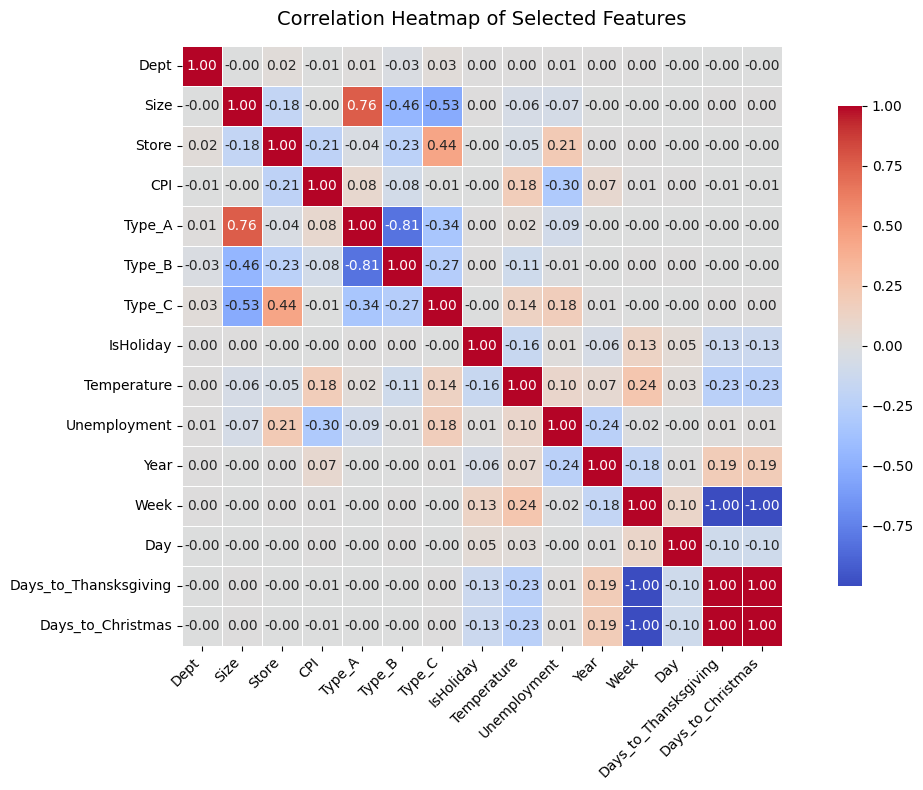

In [41]:
selected_features = [
'Dept','Size','Store','CPI','Type_A', 'Type_B', 'Type_C', 'IsHoliday', 
'Temperature','Unemployment', 'Year', 'Week', 'Day', 'Days_to_Thansksgiving', 'Days_to_Christmas'
]

corr_df = X[selected_features].copy()

corr_matrix = corr_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Heatmap of Selected Features", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
selected_features = ['Store','Dept','IsHoliday','Size','Type_A', 'Type_B', 'Type_C', 'Year', 'Week', 'Day']

In [43]:
X_pruned = X[selected_features]
X_pruned_train = X_train[selected_features]
X_pruned_val = X_val[selected_features]

In [44]:
scoring = {
    'RMSE': rmse_scorer,
    'WMAE': wmae_scorer
}

In [45]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

In [46]:
rfm_grid = ensemble.RandomForestRegressor(random_state=0, verbose=0)

param_grid = {
    'n_estimators': [30, 60],
    'max_depth': [25, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(
    estimator=rfm_grid,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='WMAE',
    n_jobs=-1,
    verbose=2
)

print("Running Grid Search for RandomForest...")
grid.fit(X_pruned, y, sample_weight=X_weights)

results = pd.DataFrame(grid.cv_results_)

best_wmae_row = results.loc[results['mean_test_WMAE'].idxmax()]

display(best_wmae_row[['mean_test_WMAE', 'mean_test_RMSE']])
print("Best Params:", best_wmae_row['params'])

Running Grid Search for RandomForest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


mean_test_WMAE   -1394.037705
mean_test_RMSE   -3035.602199
Name: 9, dtype: object

Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}


In [47]:
rfm = ensemble.RandomForestRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=60, n_jobs=-1)
etrm = ensemble.ExtraTreesRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=60, n_jobs=-1)

In [48]:
rfm.fit(X_pruned_train, y_train)
rfm_pruned_preds = rfm.predict(X_pruned_val)

etrm.fit(X_pruned_train, y_train)
etrm_pruned_preds = etrm.predict(X_pruned_val)

print("RFM Pruned Features WMAE:", WMAE(y_val, rfm_pruned_preds, sw_val))
print("ETRM Pruned Features WMAE:", WMAE(y_val, etrm_pruned_preds, sw_val))

RFM Pruned Features WMAE: 1419.7846619033542
ETRM Pruned Features WMAE: 1509.1935733433095


In [49]:
rfm.fit(X, y)
rfm_all_preds = rfm.predict(X_test)

etrm.fit(X, y)
etrm_all_preds = etrm.predict(X_test)

In [50]:
rfm.fit(X_pruned, y)
rfm_pruned_preds = rfm.predict(X_test[selected_features])

etrm.fit(X_pruned, y)
etrm_pruned_preds = etrm.predict(X_test[selected_features])

In [51]:
submission = pd.DataFrame()
submission['Id'] = test_merged.apply(lambda x : f"{x['Store']}_{x['Dept']}_{x['Date'].strftime('%Y-%m-%d')}", axis=1)
print(submission.shape)
submission.head()

(115064, 1)


,Id
0,1_1_2012-11-02
1,1_1_2012-11-09
2,1_1_2012-11-16
3,1_1_2012-11-23
4,1_1_2012-11-30


In [ ]:
submission['Weekly_Sales'] = rfm_all_preds
submission.to_csv("./submissions/rfm_all_submission.csv", index=False)

submission['Weekly_Sales'] = etrm_all_preds
submission.to_csv("./submissions/etrm_all_submission.csv", index=False)

submission['Weekly_Sales'] = rfm_pruned_preds
submission.to_csv("./submissions/rfm_pruned_submission.csv", index=False)

submission['Weekly_Sales'] = etrm_pruned_preds
submission.to_csv("./submissions/etrm_pruned_submission.csv", index=False)

In [52]:
submission['Weekly_Sales'] = (rfm_pruned_preds + etrm_pruned_preds) / 2
submission.to_csv("./submissions/mean_ensemble_submission.csv", index=False)

In [76]:
features = ['Store','Dept','IsHoliday','Size', 'Type', 'Year', 'Week', 'Day']

categorical_features = [feature for feature in features if train_merged[feature].dtype == 'object']
boolean_features = [feature for feature in features if train_merged[feature].dtype == 'bool']
numerical_features = [feature for feature in features if feature not in categorical_features + boolean_features]

print(categorical_features)
print(boolean_features)
print(numerical_features)

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

boolean_transformer = Pipeline([
    ('bool_to_int', BoolToIntImputer()),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('bool', boolean_transformer, boolean_features),
    ('num', numerical_transformer, numerical_features)
])

['Type']
['IsHoliday']
['Store', 'Dept', 'Size', 'Year', 'Week', 'Day']


In [79]:
rfm = ensemble.RandomForestRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=60, n_jobs=-1)
etrm = ensemble.ExtraTreesRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=60, n_jobs=-1)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MeanEnsemble(models=[rfm, etrm]))
])

pipeline.fit(train_merged[features], y)

mean_ensemble_preds = pipeline.predict(test_merged[features])

submission['Weekly_Sales'] = mean_ensemble_preds
submission.to_csv("./submissions/mean_ensemble_submission.csv", index=False)

joblib.dump(pipeline, "./sales_forecasting_project/models/mean_ensemble_model.joblib")

['./sales_forecasting_project/models/mean_ensemble_model.joblib']